## 1. Importing the necessary libraries and defining constants.

In [126]:
import polars as pl
import polars.selectors as sc

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.colors as colors

import pathlib as path

 # Define the ratio of the plot.
fig_aspect_ratio : float = 4/3 # width/height ratio
height : float = 6
width: float = height * fig_aspect_ratio

# 2. Reading the data from Excel sheets.

In [127]:
expenses_df: pl.DataFrame = pl.read_excel("Expenses.xlsx", 
                                       sheet_name = "Expenses",
                                       has_header = True)

income_df:pl.DataFrame = pl.read_excel("Incomes.xlsx", 
                                       sheet_name = "Incomes",
                                       has_header = True)

expenses_df

Expense date,Where bought?,What bought?,Expense cost,Volume unit,Volume amount,Expense category,Expense subcategory,Payment method
date,str,str,f64,str,f64,str,str,str
2024-02-01,"""Biedronka""","""Ser żółty światowid""",13.98,"""gram""",600.0,"""Groceries""","""Ser""","""Card"""
2024-02-01,"""Biedronka""","""Woda gazowana muszynianka""",2.99,"""ml""",1500.0,"""Drinks""","""Woda""","""Card"""
2024-02-01,"""Biedronka""","""Ryż brązowy plony natury""",8.97,"""gram""",1200.0,"""Groceries""","""Ryż""","""Card"""
2024-02-01,"""Biedronka""","""Serek wiejski""",5.97,"""gram""",600.0,"""Groceries""","""Serek wiejski""","""Card"""
2024-02-01,"""Biedronka""","""Olej słonecznikowy""",7.99,"""ml""",1000.0,"""Groceries""","""Olej spożywczy""","""Card"""
…,…,…,…,…,…,…,…,…
2025-02-20,"""Dino""","""Woda niegazowana bystry zdrój""",0.99,"""ml""",1500.0,"""Drinks""","""Woda""","""Karta"""
2025-02-20,"""Dino""","""Rogal 7Days""",3.99,"""gram""",110.0,"""Groceries""","""Rogal""","""Karta"""
2025-02-20,"""Pizzeria Diabolo""","""Pizza Salame duża""",44.0,"""sztuka""",1.0,"""DiningOut""","""Pizza""","""Karta"""


# 3. Grouping the costs by month and year.

In [128]:
grouped_cost: pl.DataFrame = (   expenses_df.group_by(pl.col("Expense date").dt.year().alias("Year"),
                                                   pl.col("Expense date").dt.quarter().alias("Quarter"),
                                                   pl.col("Expense date").dt.strftime("%b").alias("Month"),
                                                   maintain_order = True).
                                                   agg(pl.col("Expense cost").sum().alias("Total expenses")) )


grouped_income:pl.DataFrame = ( income_df.group_by( pl.col("Income date").dt.year().alias("Year"),
                                                 pl.col("Income date").dt.quarter().alias("Quarter"), 
                                                 pl.col("Income date").dt.strftime("%b").alias("Month"), 
                                                 maintain_order = True).
                                                agg(pl.col("Income amount").sum().alias("Total incomes")) )


## 4. Preprocessing the balance sheet for plotting.

In [129]:
# Join the grouped_income with grouped_cost.
balances:pl.DataFrame    = grouped_income.join(grouped_cost, on = (pl.col("Year"), pl.col("Month")),
                                                    how = "full").select(~sc.ends_with("right")).fill_null(0)


# Add a column "Miesięczne saldo"
balances:pl.DataFrame = balances.with_columns( (pl.col("Total incomes") - pl.col("Total expenses")).alias("Monthly balance"))


# Convert the balance sheet to long form.
balances_long:pl.DataFrame = balances.unpivot(index = ("Year","Quarter", "Month"),
                                                              variable_name = "Financial category",
                                                             value_name = "Amount")

fin_cat:pl.Expr = pl.col("Financial category")


hue_variable: pl.Expr = ( pl.when( fin_cat.is_in( ["Total incomes", "Total expenses"])).
                         then(
                             fin_cat
                             ).otherwise( 
                                 pl.when(pl.col("Amount") >=0).
                                 then(pl.lit("Positive balance")).
                                 otherwise(pl.lit("Negative balance"))
                             ).alias("Financial category") 
                             )

balances_long: pl.DataFrame = balances_long.with_columns(hue_variable)

balances_long


Year,Quarter,Month,Financial category,Amount
i32,i8,str,str,f64
2024,1,"""Feb""","""Total incomes""",1468.0
2024,1,"""Mar""","""Total incomes""",1070.0
2024,2,"""Apr""","""Total incomes""",1606.5
2024,2,"""May""","""Total incomes""",1630.0
2024,2,"""Jun""","""Total incomes""",1928.0
…,…,…,…,…
2024,4,"""Oct""","""Positive balance""",448.86
2024,4,"""Nov""","""Positive balance""",515.225
2024,4,"""Dec""","""Positive balance""",2380.78


## 5. Visualizing the annual general balance sheets.

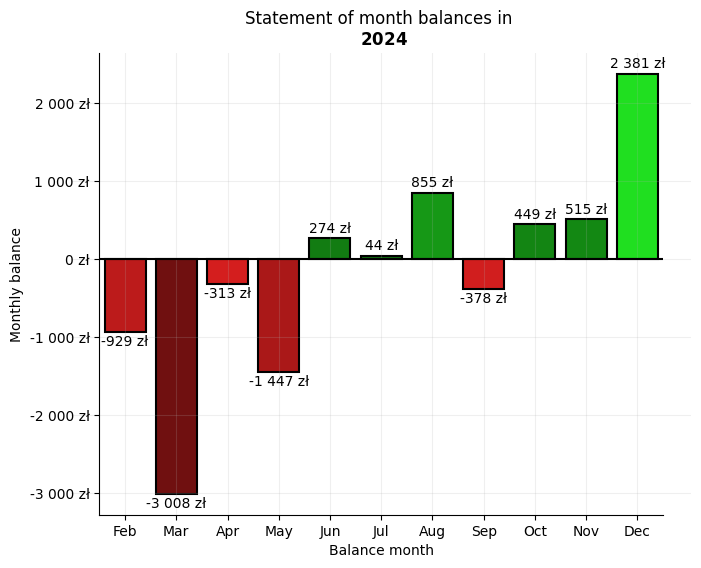

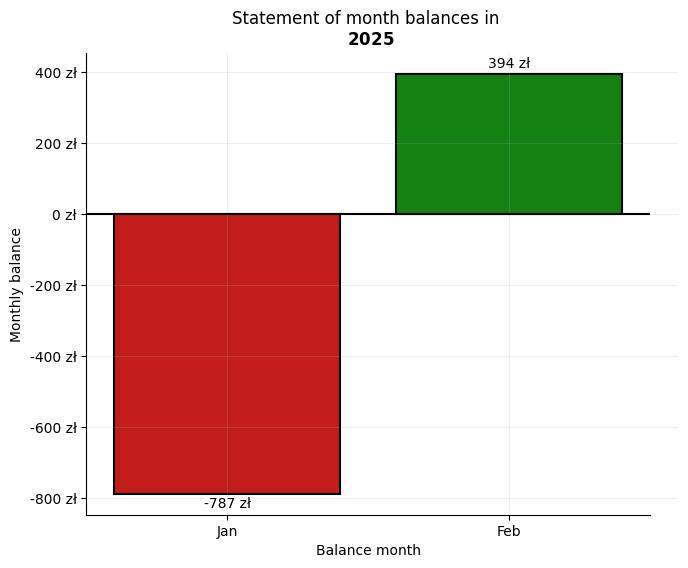

In [130]:
monthly_balances:pd.DataFrame = balances_long.filter(pl.col("Financial category").str.ends_with("balance"))

monthly_general_balances_path: path.Path = path.Path().cwd()/r"General monthly balances"


# Create a Normalizer for our data for the color map to work properly.
Normalize = colors.Normalize(monthly_balances["Amount"].min(), monthly_balances["Amount"].max())

# Find the "turning" normalized value (that is, if Normalize(x) < x0 then x is negative, otherwise - positive)
x0 = Normalize(0)

# Define the color entries for the LinearSegmentedColorMap.
red : list[tuple[int]] = [(0, 0, 0.5), (x0, 1, 0), (1, 0, 0)]
green : list[tuple[int]] = [(0, 0, 0), (x0, 0 ,0.5), (1, 1, 1)]
blue : list[tuple[int]] =  [(0, 0, 0), (1, 0, 0)]
alpha: list[tuple[int]] = [(0, 1, 1), (x0, 0, 0), (1, 1,1)]



# Let's create a custom color map
financial_colormap = colors.LinearSegmentedColormap("FinancialPalette", 
                                            {"red": red, "green": green, "blue": blue,
                                            "alpha": alpha})



def generate_month_balance_sheet(year:int) -> None:
    """The function generates the month balance sheet plot for a given year. All of the plots are saved in a given path.
    
    Parameters:
    ---------
    year: int
        The year of the month balances.

    Returns:
    None

    """
    # Filter the balance sheet by year.
    df_filtered = monthly_balances.filter(pl.col("Year") == year)


    # Convert the values to color.
    kolory = [financial_colormap(Normalize(v)) for v in df_filtered["Amount"]] 


    # Create a figure
    global width, height
    figure = plt.figure(figsize = (width, height))
    axes = sns.barplot(data=df_filtered, x="Month", y="Amount", 
                       palette=kolory, hue = "Month", 
                       legend = False,
                       edgecolor = "black", linewidth = 1.5)


    xlim: tuple[float] = axes.get_xlim()

    # Customizing the plot.
    axes.spines[["top", "right"]].set_visible(False)
    axes.grid(True, alpha = 0.2)

    # Setting the title of the plot and axis labels.
    axes.set_title("Statement of month balances in \n"+ rf"$\bf{{\ {year}}}$")
    axes.set_ylabel("Monthly balance")
    axes.set_xlabel("Balance month")

    # Adjust the  bounds of the bottom spine
    xlim: tuple[float] = axes.get_xlim()

    # Rebounding the bottom spine.
    axes.spines["bottom"].set_bounds(xlim[0], xlim[1])
    
    # Set the position of the left spine.
    axes.spines["left"].set_position(("data",xlim[0]))

    # Add a new Ox axis at position y =0.
    axes.hlines(0, xlim[0], xlim[1], colors = "black")
    
    # Set the major formatter for the yaxis.
    axes.yaxis.set_major_formatter(lambda x,v: f"{x:,.0f} zł".replace(",", " "))

    
    for container in axes.containers:
        axes.bar_label(container, fmt = lambda v: f"{v:,.0f} zł".replace(",", " "), padding = 2)


    if not monthly_general_balances_path.exists():
        monthly_general_balances_path.mkdir()
    
    figure.savefig(fname = monthly_general_balances_path/rf"Month financial balances for the year {year}")

# Generate the month balance sheets for each year available in the dataset.
for year in monthly_balances["Year"].unique():
    generate_month_balance_sheet(year)



# 7. Visualizing the income and expenses for each month.

### For a given year, we group the income and expenses by quarter and visualize these groups on a single plot.

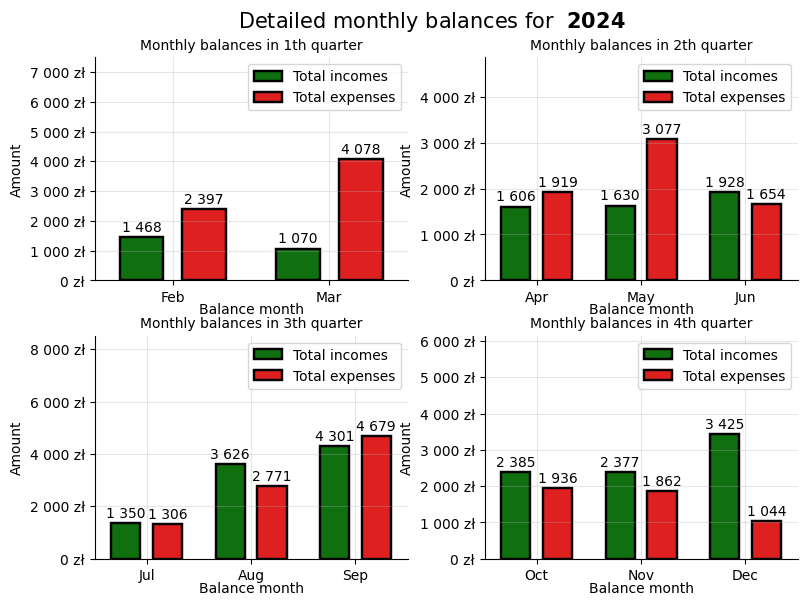

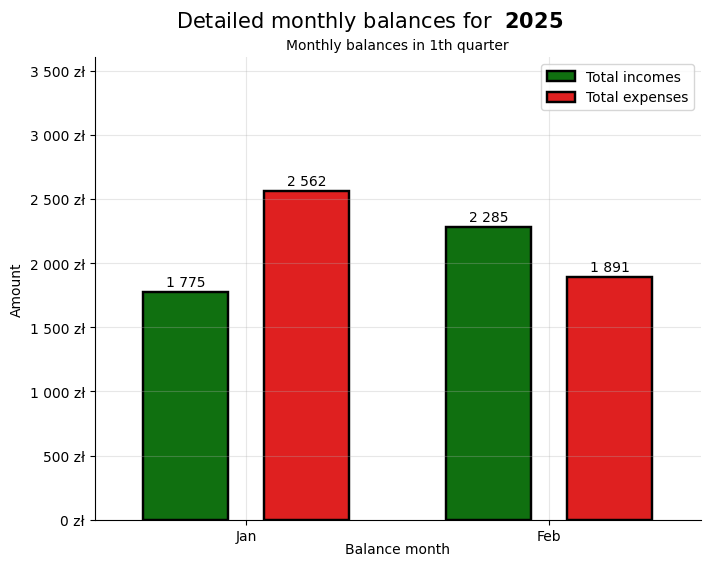

In [131]:
monthly_detailed_balances_path: path.Path = path.Path().cwd()/r"Detailed monthly balances"


def generate_month_detailed_balances(year:int) -> None:
    # Filter the balance sheets and add a new column for "signed" amount.
    year_balance_sheets: pl.DataFrame = ( balances_long.
                                        filter(pl.col("Year") == year, 
                                                pl.col("Financial category").str.starts_with("Total"))
                                                
                                                )


    FacetGrid = sns.FacetGrid(data = year_balance_sheets, col = "Quarter", col_wrap = min(2, year_balance_sheets["Quarter"].n_unique()), sharex = False, sharey = False)
    # Set title for each subplot.
    FacetGrid.set_titles(template = "Monthly balances in {col_name}th quarter")
    # Set the global title for the whole figure.

    FacetGrid.fig.suptitle(fr"Detailed monthly balances for  $\bf{{{year}}}$",
                           size = 15)
    
    FacetGrid.fig.subplots_adjust(top=0.9)  # Lif the title a little bit.



    for quarter_id, axes in FacetGrid.axes_dict.items():
        # Find the rows from a given quarter.
        quarter_balance_sheets: pl.DataFrame = year_balance_sheets.filter(pl.col("Quarter") == quarter_id)

        sns.barplot(quarter_balance_sheets, x = "Month", y = "Amount", hue = "Financial category",
                    ax = axes,
                    palette = {"Total expenses":"red", "Total incomes":"green"},
                    edgecolor = "black",
                    linewidth = 1.75
                    )

        # Find the minimum and maximum amount respectively.
        y_min, y_max = quarter_balance_sheets["Amount"].min(), quarter_balance_sheets["Amount"].max()

        legend = axes.get_legend()
        axes.get_legend().set_title("")

        axes.set_xlabel("Balance month", labelpad = -1)

        axes.set_ylim(0, y_max*(  1.1 + (y_max-y_min)/y_max))
        axes.yaxis.set_major_formatter(lambda x,v: f"{x:,.0f} zł".replace(",", " "))

        axes.grid(True, alpha = 0.3)

        # Add bar labels.
        for i in range(len(axes.containers)):
            axes.bar_label(axes.containers[i], fmt = lambda v: f"{v:,.0f}".replace(",", " "),
                           padding = 2)
        
        # Resize the width of the bars so that the bar labels wouldn't overlap.
        q: float = 0.7
        for patch in axes.patches:
           current_width: float = patch.get_width()

           patch.set_width(w = current_width*q)
           patch.set_x( patch.get_x() +  current_width/2 *(1-q))
        
    # Get the figure.
    figure: plt.Figure = axes.get_figure()
    
    # Change the shapes of the figure.
    figure.set_size_inches((width, height))

    
    if not monthly_detailed_balances_path.exists():
        monthly_detailed_balances_path.mkdir()
    
    figure.savefig(monthly_detailed_balances_path/rf"Month financial balances for the year {year}")




for year in balances_long["Year"].unique():
    generate_month_detailed_balances(year)  

# 8. Visualizing the share of expense categories in monthly spendings.

C:\Users\pawel\AppData\Local\Temp\ipykernel_2612\1909602558.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6, 3))


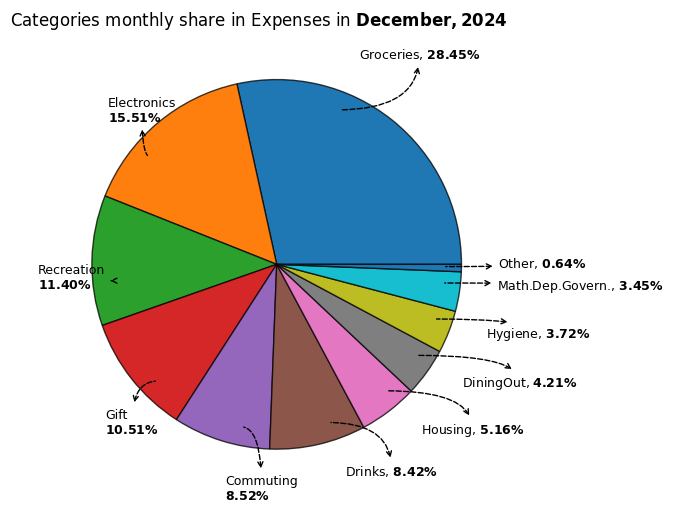

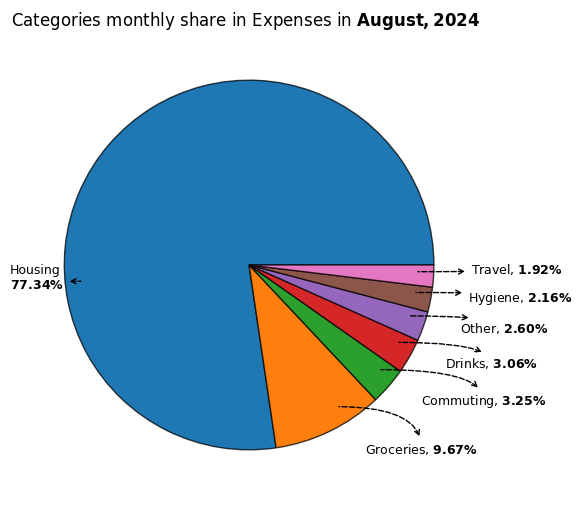

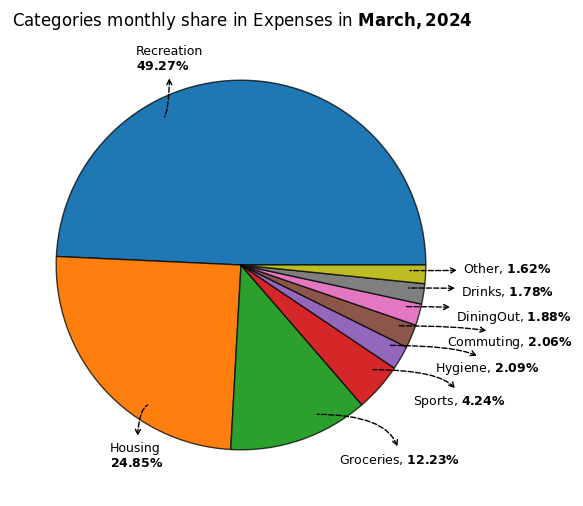

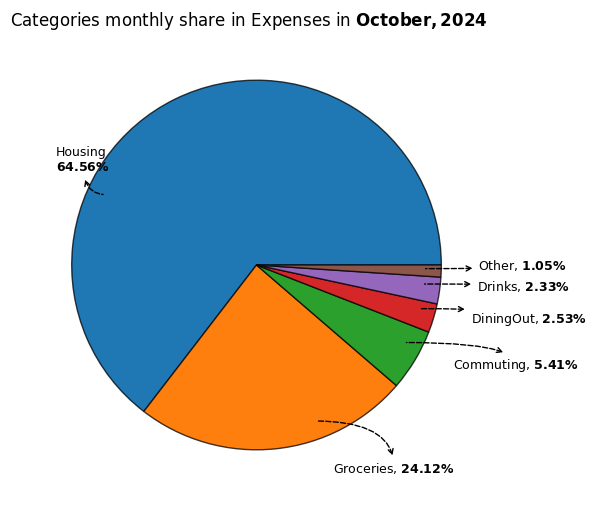

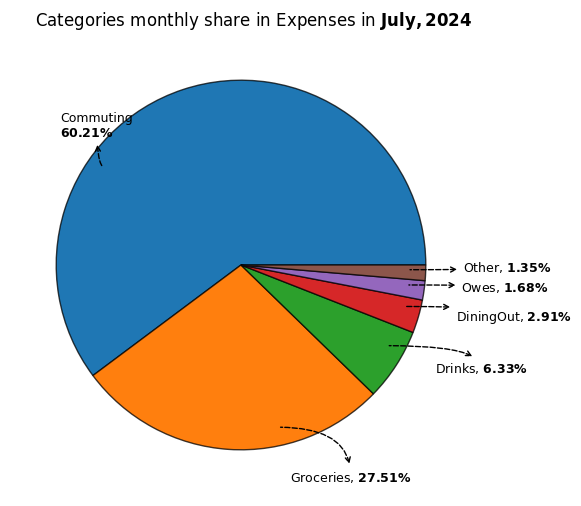

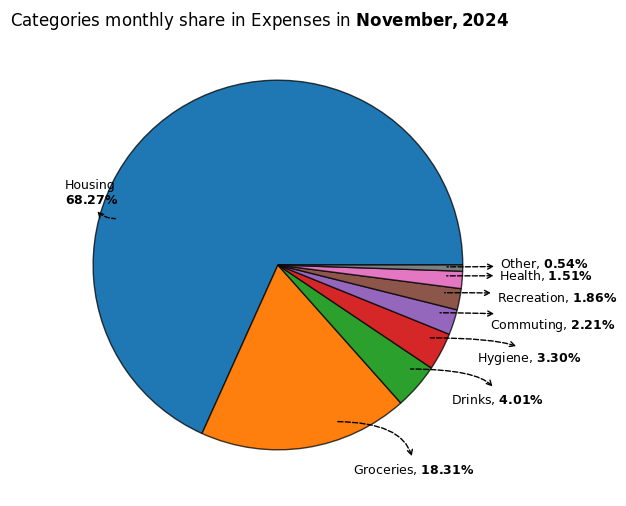

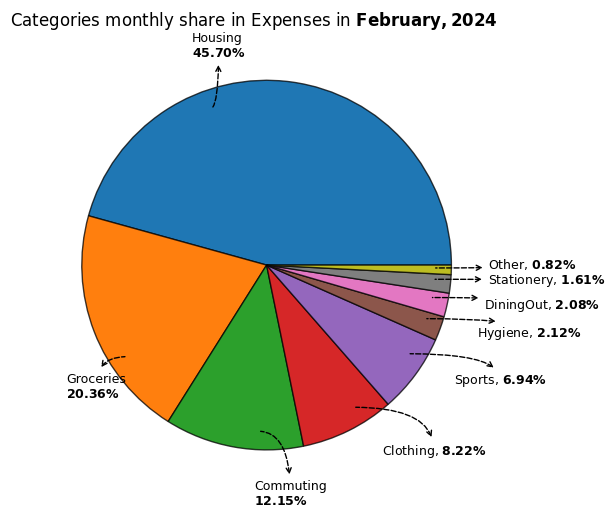

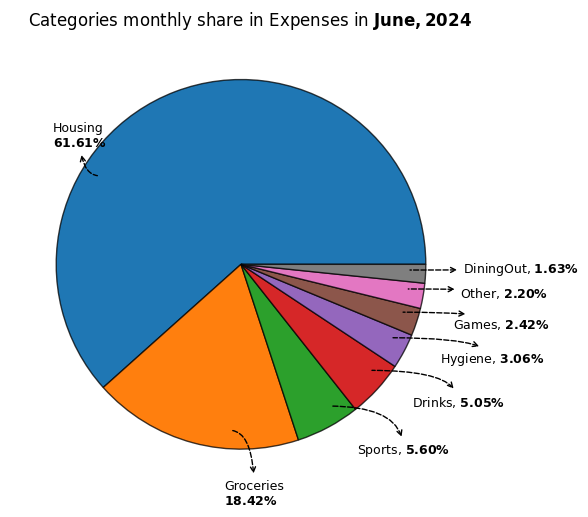

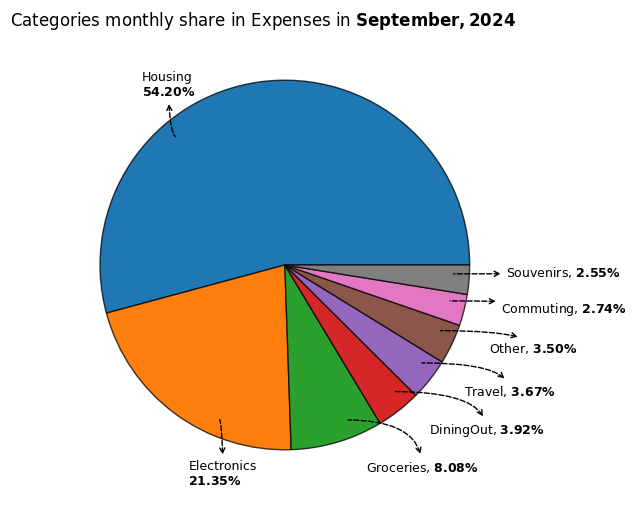

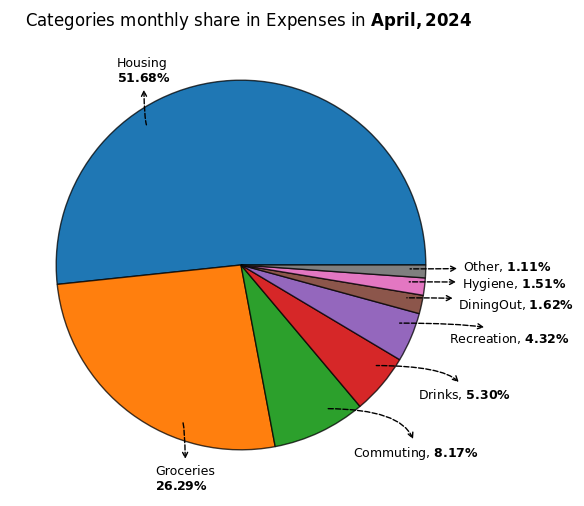

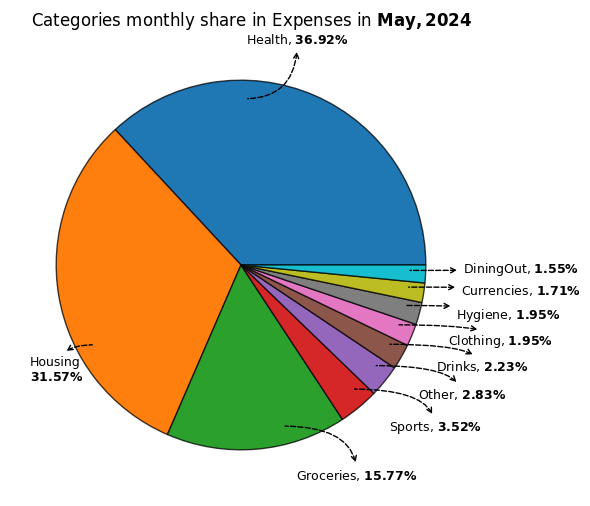

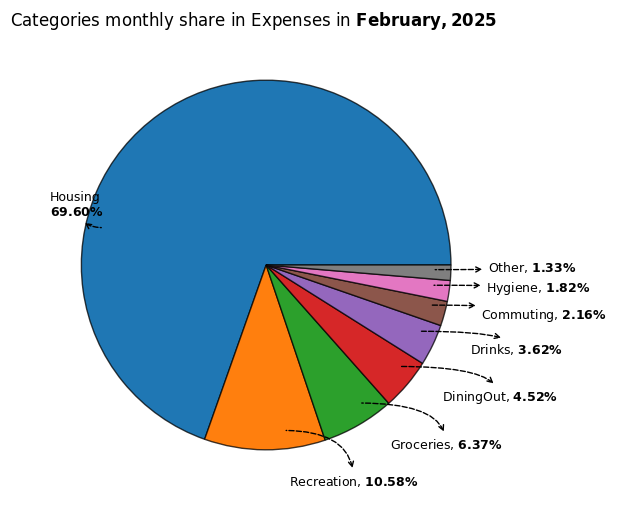

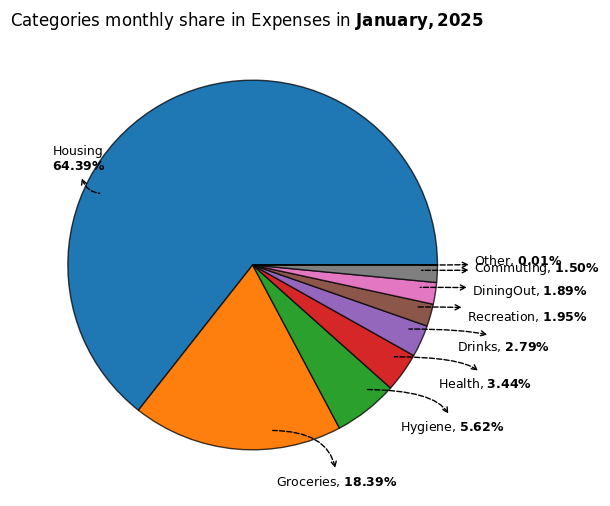

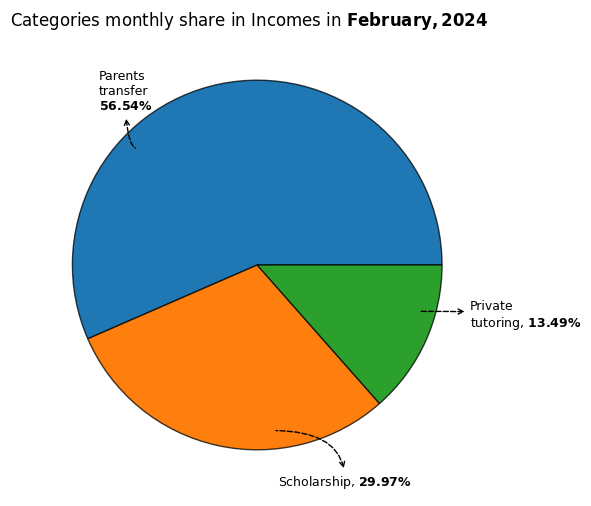

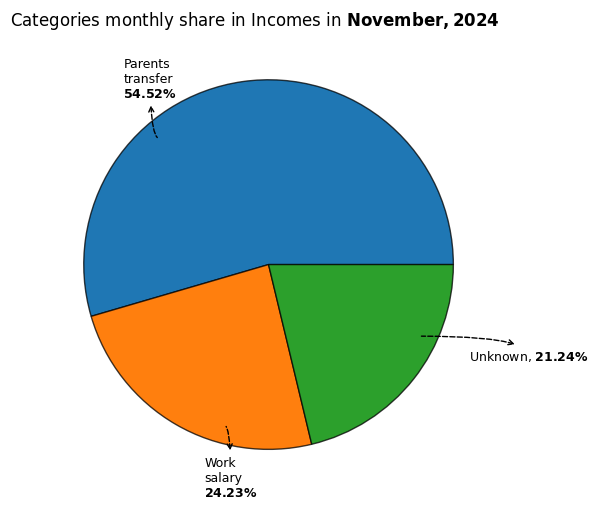

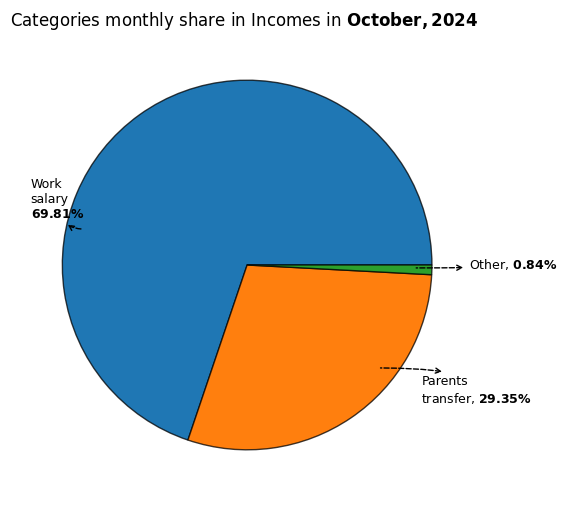

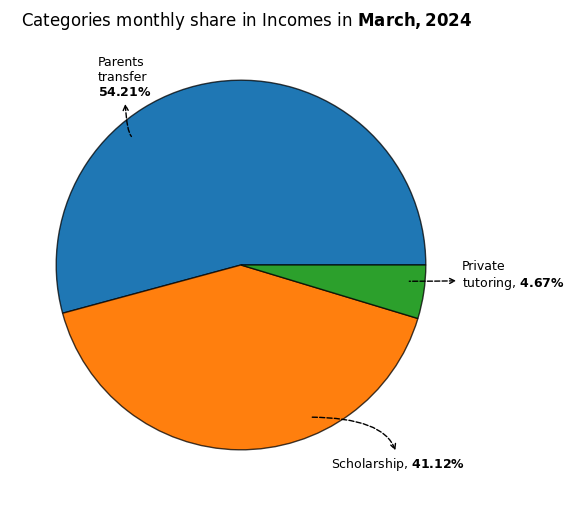

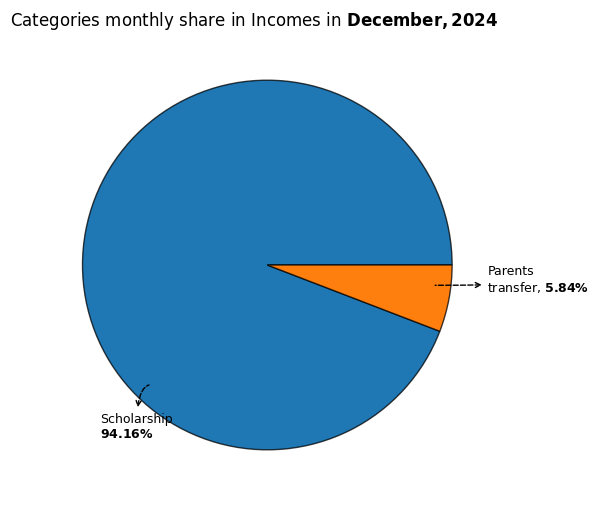

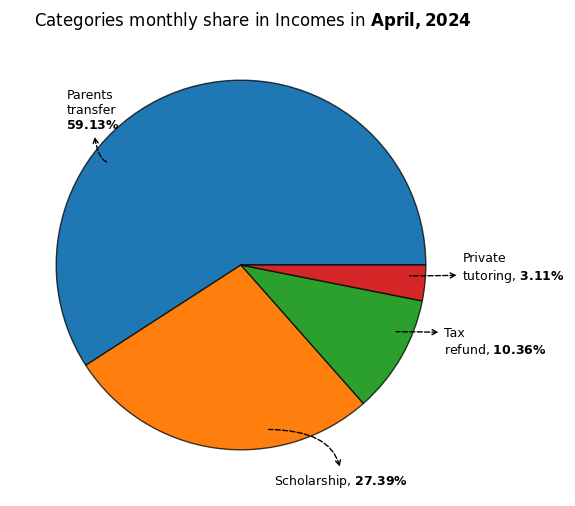

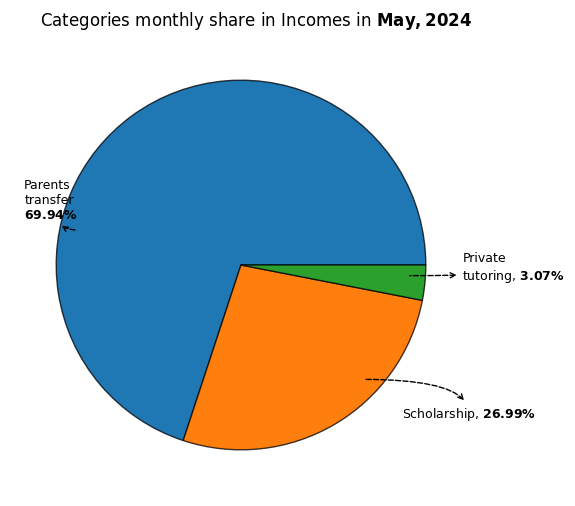

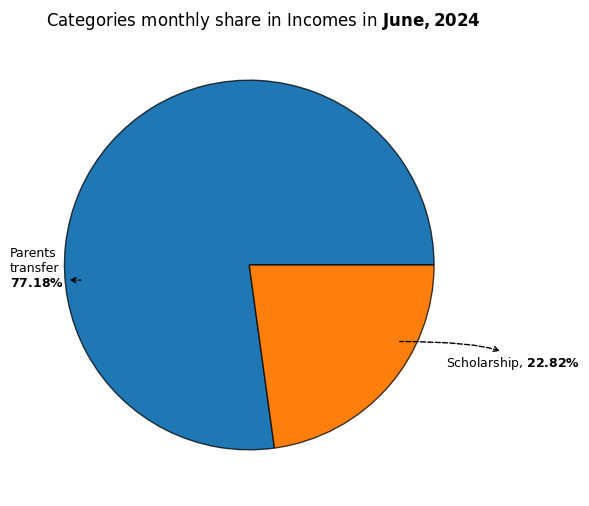

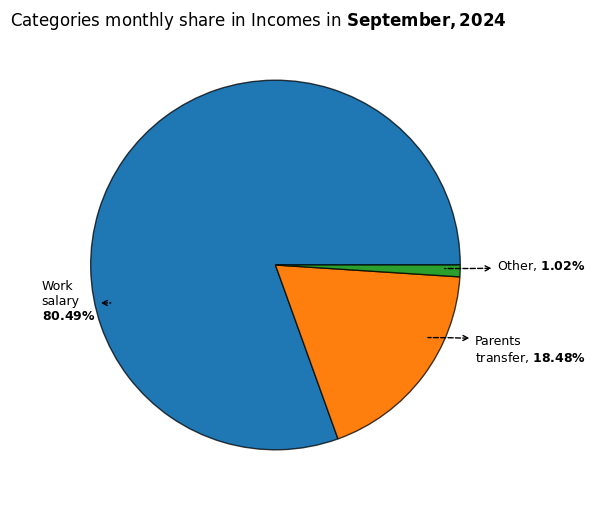

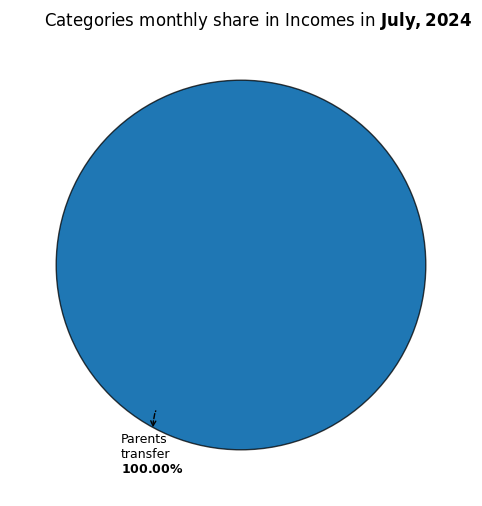

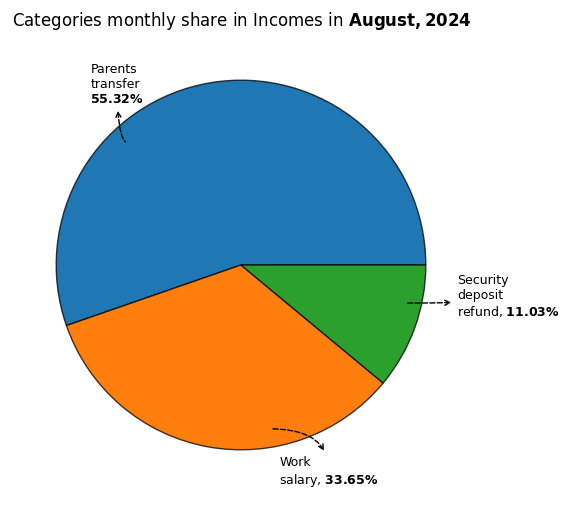

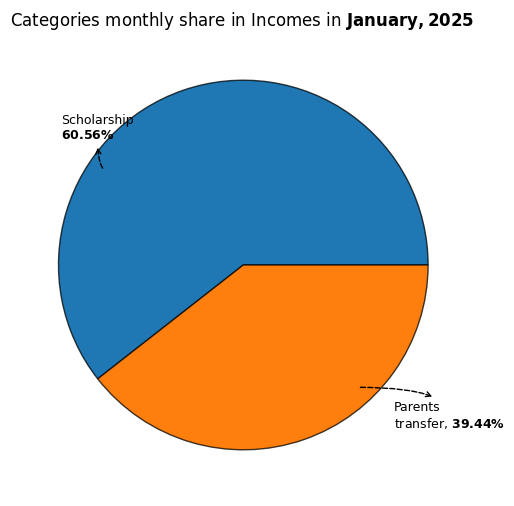

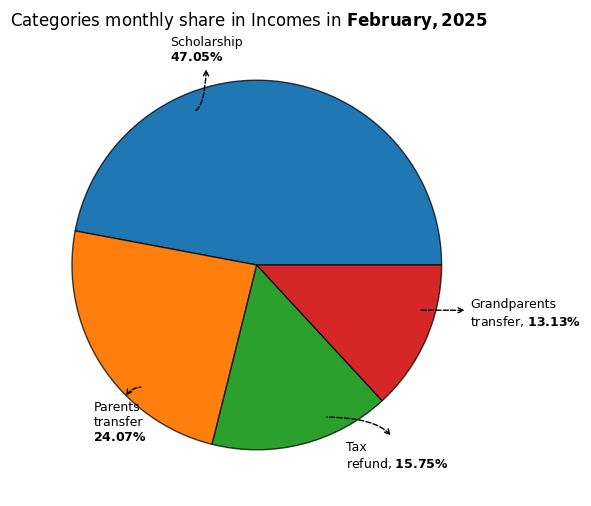

In [132]:
import numpy as np

def plot_the_share(df:pl.DataFrame, 
                   date_col:str, cat_col:str, cost_col: str, 
                   transaction_type:str,
                     ) -> None:
    """"The function visualize the categories share in either expenses or incomes.

    Parameters:
    df : pl.DataFrame
        The dataframe storing the expenses or incomes.

    date_col : str
        The name of the date column.

    cat_col : str
        The name of the (expense/income) category column.

    cost_col : str
        The name of the cost column.

    transaction_type : str
        One of two of types of transaction (expenses, costs) we're vizualising.

    
    """
    cat_share_path:path.Path =  path.Path().cwd()/f"Categories monthly {transaction_type[:-1].lower()} share"

    cat_share: pl.DataFrame = df.group_by(pl.col(date_col).dt.year().alias("Year"),
                                                            pl.col(date_col).dt.strftime("%B").alias("Month"),
                                                            pl.col(cat_col)).agg(pl.sum(cost_col).alias("Total amount"))

    for year in cat_share["Year"].unique():
        for month in cat_share["Month"].unique():
            # Filter out the monthly expenses and add a normalized amount of the expenses. 
            cat_share_filtered : pl.DataFrame = ( cat_share.filter(pl.col("Year")== year,pl.col("Month") == month).
            with_columns((100*pl.col("Total amount")/pl.sum("Total amount")).alias('Share'))
            )

        

            if cat_share_filtered.shape[0]:
                # Create a condition to group the least-expensive categories.
                grouping_condition: pl.Expr = ( pl.when(pl.col("Share") <=1.5)
                .then(pl.lit("Other"))
                .otherwise(pl.col(cat_col)).
                alias(cat_col) )

                # Group the least-expensive categories together.
                cat_share_filtered : pl.DataFrame = ( cat_share_filtered.with_columns(grouping_condition )
                .group_by(pl.col(cat_col)).
                agg(pl.sum("Total amount"), pl.sum("Share")) ).sort(pl.col("Share"), descending = True)


                # Create a figure.
                fig, ax = plt.subplots(figsize=(6, 3))

                # Resize the figure.
                global height, width
                fig.set_size_inches(width, height)


                wedges, empty_labels = plt.pie(cat_share_filtered["Share"],
                        wedgeprops = {"edgecolor":(0, 0,0, 0.75), "linewidth":1},
                        )
                
                # Find the labels of each wedge.
                labels : pl.Series = cat_share_filtered[cat_col]


                # Define the formatter for procentage share.
                text_formatter: callable = lambda t: f"{t:.2f}" 

                for i, (label, wedge, share) in enumerate(zip(labels, wedges, cat_share_filtered["Share"])):

                    # Find the starting and ending angles of the wedge.
                    theta1, theta2 = wedge.theta1, wedge.theta2

                    # Find the radius of the wedge.
                    radius: float = wedge.r

                    # Find the angle of the point the label will be locacated at.
                    angle:float = np.deg2rad((theta1+2*theta2)/3)

            
                    # Find the cordinates of the circle edge point.
                    x:float = np.cos(angle) * radius
                    y:float = np.sin(angle) * radius


                    # The point from the circumference.
                    xy:np.ndarray = np.array([x,y])
                    
                    # The tail point scaling factor.
                    if x >= 0:
                        q:float = 1.2
                    else:
                        q: float = 1.2 if y >= 0 else 1.3


                    # The arrow tail cordinates caling factor, which should be in the [0;1] Interval
                    s:float = 0.9

                    # Cind the tail and head of the arrow.
                    arrow_tail_xy: float = s*xy
                    arrow_head_xy: float = q*xy


                    # Create a good-looking label depending on the orientation of the Wedge.
                    text = (label.replace(" ", "\n")  + (", " if x >=0 else  "\n")  + fr"$\bf{{{text_formatter(share)}}}\%$")


                    ax.annotate(text = text , xy = arrow_tail_xy, xytext = arrow_head_xy,
                                arrowprops = {"arrowstyle":"<-", "connectionstyle":"Angle3",
                                            "color":"black", "linewidth":1, "linestyle":"dashed"},
                                fontsize = 9
                                    
                                )   
                    
                    ax.set_title(f"Categories monthly share in {transaction_type} in " +rf"$\bf{{{month}, {year}}}$",loc = "right",
                    fontsize  = 12)

                    # A path where we save the chart.
                    pie_path: path.Path = cat_share_path/rf"{year}"

                    pie_path.mkdir(parents = True, exist_ok = True)

                    #Save the figure.
                    fig.savefig(fname = pie_path/rf"{month}")
                

    
plot_the_share(expenses_df, "Expense date", "Expense category", "Expense cost", "Expenses")
plot_the_share(income_df, "Income date", "Income category", "Income amount", "Incomes")

# 9. Operations history.